In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

# style.use('seaborn-v0_8-whitegrid')
from IPython.display import display

model_names = [
    'transformer',
    'resnet18',
    'resnet50'
    ]

# set this to be the same as the one in the experiment
model_idx = 2

model = model_names[model_idx]

data_file = f'out/{model}.csv'

df = pd.read_csv(data_file)

name_to_rank = {}
for _, row in df.iterrows():
    name_to_rank[row['name']] = row['rank']

df['type'].value_counts()
display(df.head())
display(df['type'].value_counts())

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],"{convolution: None, convolution_backward_52: N...",37632.0,37632.0,0.044373,NodeType.PARAM,319080960,319080960,319080960,convolution,convolution,convolution_backward_52,copy__1932,copy__1932
1,1,arg0_2,placeholder,arg0_2,[],"{cudnn_batch_norm: None, cudnn_batch_norm_back...",256.0,256.0,0.022528,NodeType.PARAM,319080960,319080960,319080960,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_backward_52,copy__1933,copy__1933
2,2,arg0_3,placeholder,arg0_3,[],"{cudnn_batch_norm: None, _foreach_addcdiv: Non...",256.0,256.0,0.021845,NodeType.PARAM,319080960,319080960,319080960,cudnn_batch_norm,cudnn_batch_norm,_foreach_addcdiv,copy__1934,copy__1934
3,3,arg0_4,placeholder,arg0_4,[],"{convolution_1: None, convolution_backward_51:...",16384.0,16384.0,0.019797,NodeType.PARAM,319080960,319080960,319080960,convolution_1,convolution_1,convolution_backward_51,copy__1935,copy__1935
4,4,arg0_5,placeholder,arg0_5,[],"{cudnn_batch_norm_1: None, cudnn_batch_norm_ba...",256.0,256.0,0.018773,NodeType.PARAM,319080960,319080960,319080960,cudnn_batch_norm_1,cudnn_batch_norm_1,cudnn_batch_norm_backward_51,copy__1936,copy__1936


NodeType.OTHER                5335
NodeType.GRAD_INTERMEDIATE     290
NodeType.ACT                   269
NodeType.ACT_DISCARD           181
NodeType.PARAM                 161
NodeType.GRAD                  161
Name: type, dtype: int64

In [2]:
# some preprocessing
df['mem_cuda_GB'] = df.mem_cuda * 1e-9
df['mem_cuda_pre_GB'] = df.mem_cuda_pre * 1e-9
df['mem_cuda_peak_GB'] = df.mem_cuda_peak * 1e-9


op_start = df[df.op == 'call_function']['rank'].min()
sep_rank = df[df.name == 'sep']['rank'].item()
sep_back_rank = df[df.name == 'sep_backward']['rank'].item()
opt_start = df[df.name == '_foreach_lerp_']['rank'].item()

print(op_start, sep_rank, sep_back_rank, opt_start)

df_grad = df[:opt_start]
df_grad[op_start:].head()

807 1256 1259 2033


,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,...,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use,mem_cuda_GB,mem_cuda_pre_GB,mem_cuda_peak_GB
807,807,convolution,call_function,aten.convolution.default,"[arg3_3, arg0_1]","{cudnn_batch_norm: None, cudnn_batch_norm_back...",12845056.0,12845056.0,0.313685,NodeType.ACT,...,331926016,347217408,cudnn_batch_norm,cudnn_batch_norm,cudnn_batch_norm_backward_52,cudnn_batch_norm_backward_52,cudnn_batch_norm_backward_52,0.331926,0.331926,0.347217
808,808,add_,call_function,aten.add_.Tensor,[arg1_3],{},8.0,0.0,0.072704,NodeType.ACT_DISCARD,...,331926016,347217408,NaN,NaN,NaN,NaN,NaN,0.331926,0.331926,0.347217
809,809,cudnn_batch_norm,call_function,aten.cudnn_batch_norm.default,"[convolution, arg0_2, arg0_3, arg1_1, arg1_2]","{getitem: None, getitem_1: None, getitem_2: No...",12845568.0,12845568.0,0.148139,NodeType.ACT_DISCARD,...,344772096,347217408,getitem,getitem_3,NaN,NaN,getitem_3,0.344772,0.344772,0.347217
810,810,getitem,call_function,<built-in function getitem>,[cudnn_batch_norm],{relu_: None},12845056.0,0.0,0.023552,NodeType.ACT_DISCARD,...,344772096,347217408,relu_,relu_,NaN,NaN,relu_,0.344772,0.344772,0.347217
811,811,getitem_1,call_function,<built-in function getitem>,[cudnn_batch_norm],{cudnn_batch_norm_backward_52: None},256.0,0.0,0.020139,NodeType.ACT,...,344772096,347217408,NaN,NaN,cudnn_batch_norm_backward_52,cudnn_batch_norm_backward_52,cudnn_batch_norm_backward_52,0.344772,0.344772,0.347217


In [3]:
# make sure to give a minimum allocation size
# DOES NOT CHANGE ANYTHING
df['size'] = df['size'].where(df['size'] > 512, 512)

In [4]:
# compute memory usage here

memory_usage = np.zeros(df.shape[0])

for _, row in df.iterrows():

    
    start = row['rank']
    if row['op'] == 'placeholder':
        start = 0
    end = df.shape[0]

    if not pd.isna(row['last_use']):
        end = name_to_rank[row['last_use']]

    memory_usage[start:end] += row['size']

memory_usage

array([3.09430752e+08, 3.09430752e+08, 3.09430752e+08, ...,
       3.06810240e+08, 3.06806240e+08, 2.91840000e+04])

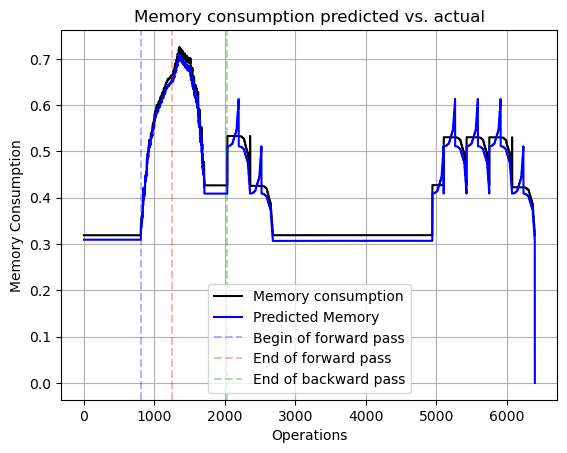

In [5]:
plt.grid()
plt.plot(df.mem_cuda_GB, color = 'k', label='Memory consumption')
plt.plot(memory_usage/1e9, color='b', label='Predicted Memory')

plt.title('Memory consumption predicted vs. actual')
plt.xlabel('Operations')
plt.ylabel('Memory Consumption')

plt.axvline(op_start, color='b', linestyle='--', alpha=0.3, label='Begin of forward pass')
plt.axvline(sep_rank, color='r', linestyle='--', alpha=0.3, label='End of forward pass')
plt.axvline(opt_start, color='g', linestyle='--', alpha=0.3, label = 'End of backward pass')
plt.legend()
plt.savefig(f'figs/memory_prediction_{model}.png')
plt.show()

In [ ]:
from dataclasses import dataclass
from typing import List
@dataclass
class Object:
    name :str
    id : int
    children : List

    def __str__(self):
        return self.name
    
    
obj = Object('kerem', 1, [Object('ad', 2, [])])
def obj_list_to_array(lst):
    if len(lst) == 0:
        return []

    keys = list(filter(lambda x: x[:2] != '__' and x[-2:] != '__', dir(lst[0])))

    ret = [keys]

    for l in lst:
        row = []
        for key in keys:
            val = getattr(l, key)
            row.append(val)
        
        ret.append(row)
    
    return ret

lst = [obj]

obj_list_to_array(lst)


[['children', 'id', 'name'],
 ["[Object(name='ad', id=2, children=[])]", '1', 'kerem']]